In [ ]:
import numpy as np
from keras.layers import Flatten
from keras import Input
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
import torch

path = "datasets2022.npz"
data = np.load(path)
X_train = data['train']
y_train = data['y_train']
X_test = data['test']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=False)
X_val1 = X_val.copy()## Autoencoder

## Autoencoder

In [ ]:
epoch=15
batch_size=1024
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )
ae.fit(X_train, y_train,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)
encoder = models.Model(input_tensor, latent_vector)
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))
encoded_x = encoder.predict(X_test)

In [ ]:
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]
for f in y_train : 
    # skip none case
    if f == 'none' : 
        continue
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))
for i in range(X_train.shape[0]):
    img = Image.fromarray(X_train[i]*255)
    img = img.convert('RGB')
    img_blur=img.filter(ImageFilter.ModeFilter(3))
    img = img_blur.convert('F')
    X_train[i] = np.array(img)/255

## Train set and Validation set (PyTorch Version)

In [ ]:
def five_fold_validation(X, Y, alpha, times, fold_number):
    data_size = len(Y)
    each_fold_size = data_size // fold_number
    fold = []
    accuracy = []
    for k in range(fold_number):
        fold_k = make_array(X[k*each_fold_size:(k+1)*each_fold_size,:], Y[k*each_fold_size:(k+1)*each_fold_size])
        fold.append(fold_k)
    k = 0
    for i in range(each_fold_size*fold_number, data_size):
        app = np.ones((1,4))
        app[0, 0:3] = X[i]
        app[0, 3] = Y[i]
        fold[k] = np.concatenate((fold[k],app))
        k = k + 1
    for i in range(fold_number):
        train_set = np.concatenate([fold[t] for t in list(set([0,1,2,3,4])-{i})])
        test_set = fold[i]
        beta = lg(train_set[:,0:3], train_set[:,3], alpha, times)
        Y_predict = [1 if g(beta, test_set[i,0:3]) > 0.5 else 0 for i in range(test_set.shape[0])]
        accuracy_i = 0
        for j in range(test_set.shape[0]):
            if test_set[j, 3] == Y_predict[j]:
                accuracy_i += 1
        accuracy_i = accuracy_i / test_set.shape[0]
        accuracy.append(accuracy_i)
        for i in range(test_set.shape[0]):
            print('{:<3} {:<7} {:<5}'.format(test_set[i,3], round(g(beta, test_set[i,0:3]), 4), Y_predict[i]))
    score = np.mean(np.array(accuracy))
    print("score = {}".format(score))
    return beta

In [ ]:
train_data = X_train[0:round(0.8*X_train.shape[0])].reshape((24330,1,52,52))
train_label = y_train[0:round(0.8*y_train.shape[0])]
validate_data = X_train[round(0.8*X_train.shape[0]):X_train.shape[0]].reshape((6082,1,52,52))
validate_label = y_train[round(0.8*y_train.shape[0]):y_train.shape[0]]

In [ ]:
from torch.utils.data import Dataset
class Mydata(Dataset):
    def __init__(self, input_image, label):
        self.input = input_image
        self.label = label

    def __getitem__(self, idx):
        img_idx = self.input[idx]
        label_idx = self.label[idx]
        return img_idx, label_idx
    
    def __len__(self):
        return len(self.input)

In [ ]:
train_set = Mydata(train_data, train_label)
validate_set = Mydata(validate_data, validate_label)
whole_set = Mydata(X_train, y_train)

In [ ]:
from torch.utils.data import DataLoader
batchsize = 32
train_dataloader = DataLoader(train_set, batch_size=batchsize, shuffle=True,drop_last=True)
validate_dataloader = DataLoader(validate_set, batch_size=batchsize, shuffle=True,drop_last=True)
whole_dataloader = DataLoader(whole_set,batch_size=batchsize,shuffle=True,drop_last=True)

## Model

## Model 1: VGG net

In [ ]:
def VGGLayers1(configs):
    channels = 1  # 输入通道数
    layers = []
    for (N, C) in configs:
        for _ in range(N):
            conv = torch.nn.Conv2d(channels, C, kernel_size=6, padding=3)
            layers += [conv, torch.nn.ReLU(inplace=True)]
            channels = C
        layers += [torch.nn.MaxPool2d(kernel_size=5, stride=2)]
        layers += [LazyBatchNorm2d()]
    return torch.nn.Sequential(*layers)

def VGGLayers2(configs):
    channels = 32 
    layers = []
    for (N, C) in configs:
        for _ in range(N):
            conv = torch.nn.Conv2d(channels, C, kernel_size=4, padding=1)
            layers += [conv, torch.nn.ReLU(inplace=True)]
            channels = C
        layers += [torch.nn.MaxPool2d(kernel_size=3, stride=2)]
    return torch.nn.Sequential(*layers)

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.VGG1 = VGGLayers1(configs=[(2,32)])
        self.VGG2 = VGGLayers2(configs=[(2,32),(2,3)])
        self.fc1 = torch.nn.Linear(20000, 300)
        self.fc2 = torch.nn.Linear(300, 200)
        self.fc3 = torch.nn.Linear(300, 8)
        self.droupout = torch.nn.Dropout(p=0.5)
        self.fla = Flatten()
        self.sig = Sigmoid()
    def forward(self, x):
        out = self.VGG1(x)
#         out = self.VGG2(out)
        out = self.fla(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.droupout(out)
#         out = self.fc2(out)
#         out = F.relu(out)
        out = self.droupout(out)
        out = self.fc3(out)
        out = self.sig(out)  
        return out


In [ ]:
import torch.nn as nn
train_loss = []
test_loss = []
cnn_net = Net()
loss = nn.L1Loss()
# loss = loss.cuda()
optim = torch.optim.SGD(cnn_net.parameters(),lr=0.01,momentum=0.9,nesterov=True,)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50,100,150], gamma=0.3)
# cnn_net = cnn_net.cuda()
for epoch in range(200):
    cnn_net.train()
    print("--------Epoch:{}---------".format(epoch))
    total_tloss = 0
    for data in train_dataloader:
        img, label = data
        img = img.to(torch.float32)
        label = label.to(torch.float32)
        outputs = cnn_net(img)
        outputs = outputs.squeeze()
        optim.zero_grad()
        l1loss = loss(outputs,label)
        accuracy = 0
        total_step = 0
        l1loss.backward()
        optim.step()
        total_tloss += l1loss
    train_loss.append(total_tloss)
    with torch.no_grad():
        cnn_net.eval()
        accuracy = 0
        total_step = 0
        total_loss = 0
        for data in validate_dataloader:
            img, label = data
            img = img.to(torch.float32)
            label = label.to(torch.float32)
            outputs = cnn_net(img)
            for i in range(outputs.shape[0]):
                for j in range(outputs.shape[1]):
                    if outputs[i][j] >= 0.5:
                        outputs[i][j] = 1
                    else:
                        outputs[i][j] = 0
            for i in range(outputs.shape[0]):
                jud = 1
                for j in range(outputs.shape[1]):
                    if outputs[i][j] != label[i][j]:
                        jud = 0
                accuracy += jud
                total_step += 1
            l1loss = loss(outputs,label)
            total_loss += l1loss            
            accuracy_rate = 100*accuracy/total_step
            print("Accuracy：{}%".format(accuracy_rate))
        print('totalloss = {}'.format(total_loss))
        test_loss.append(total_loss)

In [ ]:
import torch.nn as nn
train_data = X_train[0:round(0.8*X_train.shape[0])].reshape((24330,1,52,52))
train_label = y_train[0:round(0.8*y_train.shape[0])]
validate_data = X_train[round(0.8*X_train.shape[0]):X_train.shape[0]].reshape((6082,1,52,52))
validate_label = y_train[round(0.8*X_train.shape[0]):X_train.shape[0]]
train_set = Mydata(train_data, train_label)
validate_set = Mydata(validate_data, validate_label)
batchsize = 32
train_dataloader = DataLoader(train_set, batch_size=batchsize, shuffle=True,drop_last=True)
validate_dataloader = DataLoader(validate_set, batch_size=batchsize, shuffle=True,drop_last=True)
train_loss3 = []
test_loss3 = []
acc_changed = []
cnn_net = Net()
loss = nn.L1Loss()
# loss = loss.cuda()
optim = torch.optim.SGD(cnn_net.parameters(),lr=0.01,momentum=0.9,nesterov=True,)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50,100,150], gamma=0.3)
# cnn_net = cnn_net.cuda()
for epoch in range(200):
    cnn_net.train()
    print("--------Epoch: {}---------".format(epoch))
    total_tloss = 0
    for data in train_dataloader:
        img, label = data
        img = img.to(torch.float32)
        label = label.to(torch.float32)
        outputs = cnn_net(img)
        outputs = outputs.squeeze()
        optim.zero_grad()
        l1loss = loss(outputs,label)
        l1loss.backward()
        optim.step()
        total_tloss += l1loss
    train_loss3.append(total_tloss)
    with torch.no_grad():
        cnn_net.eval()
        accuracy = 0
        total_step = 0
        total_loss = 0
        for data in validate_dataloader:
            img, label = data
            img = img.to(torch.float32)
            label = label.to(torch.float32)
            outputs = cnn_net(img)
            for i in range(outputs.shape[0]):
                for j in range(outputs.shape[1]):
                    if outputs[i][j] >= 0.5:
                        outputs[i][j] = 1
                    else:
                        outputs[i][j] = 0
            for i in range(outputs.shape[0]):
                jud = 1
                for j in range(outputs.shape[1]):
                    if outputs[i][j] != label[i][j]:
                        jud = 0
                accuracy += jud
                total_step += 1
            l1loss = loss(outputs,label)
            total_loss += l1loss            
            accuracy_rate = 100*accuracy/total_step
            print("Accuracy{}%".format(accuracy_rate))
        print('totalloss = {}'.format(total_loss))
        test_loss3.append(total_loss)
        acc_changed.append(accuracy_rate)


## Model 2: Dropout

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import losses, Input, Model
from sklearn.model_selection import train_test_split
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                    input_shape=(52,52,1), data_format='channels_last',
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())  
    model.add(Dropout(0.5)) # 避免过拟合：每次训练只用50%的input
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='sigmoid')) # 转化为[0,1]概率
    model.compile(optimizer = "adam",
                    loss = "binary_crossentropy",
                    metrics = ['binary_accuracy'])
    return model


In [ ]:
import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model = build_model()
model.fit(X_train, y_train, validation_data = [X_val, y_val], batch_size=128, epochs=20,callbacks=[callback])

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, hamming_loss

def round_prob(y_prob):
    return np.round(y_prob).astype(int)
y_train_pred, y_val_pred, y_test_pred = round_prob(y_train_prob), round_prob(y_val_prob), round_prob(y_test_prob)

print("train accuracy:         ", accuracy_score(y_train_pred, y_train))
print("validation accuracy:    ", accuracy_score(y_val_pred, y_val))
print("validation precision:   ", np.round(precision_score(y_val, y_val_pred, average=None),4)) # true +ve / pred +ve
print("validation recall:      ", np.round(recall_score(y_val, y_val_pred, average=None),4))    # true +ve / all +ve
print("validation hamming loss:", hamming_loss(y_val_pred, y_val))

train accuracy:          0.9863948374368038
validation accuracy:     0.9820812099293112
validation precision:    [1.     1.     0.986  0.9995 0.993  1.     0.9913 0.9917]
validation recall:       [1.     1.     0.9961 0.9889 0.9986 1.     0.993  1.    ]
validation hamming loss: 0.0027124773960217


## Model 3：Dropblock

In [ ]:
from keras_drop_block import DropBlock2D
def build_model1():
    model = Sequential()
    model.add(DropBlock2D(block_size=7, keep_prob=0.7, name='Input-Dropout1'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                    input_shape=(52,52,1), data_format='channels_last',
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(DropBlock2D(block_size=7, keep_prob=0.7, name='Input-Dropout2'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(DropBlock2D(block_size=7, keep_prob=0.7, name='Input-Dropout3'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())  
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='sigmoid')) # 转化为[0,1]概率
    model.compile(optimizer = "adam",
                    loss = "binary_crossentropy",
                    metrics = ['binary_accuracy'])
    return model

In [ ]:
model1 = build_model1()
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model1.fit(X_train, y_train,batch_size=128,validation_data =[X_val,y_val], epochs=200,callbacks=[callback])

In [ ]:
y_train_prob1 = model1.predict(X_train)
y_val_prob1 = model1.predict(X_val)
y_test_prob1 = model1.predict(X_test)
y_train_pred1, y_val_pred1,y_test_prob1 = round_prob(y_train_prob1), round_prob(y_val_prob1), round_prob(y_test_prob1)
print("train accuracy:         ", accuracy_score(y_train_pred1, y_train))
print("validation accuracy:    ", accuracy_score(y_val_pred1, y_val))
print("validation precision:   ", np.round(precision_score(y_val, y_val_pred1, average=None),4)) # true +ve / pred +ve
print("validation recall:      ", np.round(recall_score(y_val, y_val_pred1, average=None),4))    # true +ve / all +ve
print("validation hamming loss:", hamming_loss(y_val_pred1, y_val))

238/238 [==============================] - 2s 10ms/step
train accuracy:          0.9945547810074971
validation accuracy:     0.9948704458766277
validation precision:    [1.     1.     0.9954 0.9987 0.9981 1.     1.     1.    ]
validation recall:       [1.     1.     0.9992 0.9958 0.9978 1.     0.998  1.    ]
validation hamming loss: 0.0008220439300276207


## Save Model

In [ ]:
torch.save(cnn_net.state_dict(), 'D:\\MyFile\\大三第一学期作业\\机器学习与大数据\\final_project\\yes_8_94.pth')

In [ ]:
trained_net = Net()
trained_net.load_state_dict(torch.load('D:\\MyFile\\大三第一学期作业\\机器学习与大数据\\final_project\\yes_8_94.pth'))

D:\miniconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [ ]:
trained_net = Net()
trained_net.load_state_dict(torch.load('D:\\MyFile\\大三第一学期作业\\机器学习与大数据\\final_project\\yes_8_94.pth'))

D:\miniconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    accuracy = 0
    total_step = 0
    total_loss = 0
    for data in whole_dataloader:
        img, label = data
        img = img.to(torch.float32)
        label = label.to(torch.float32)
        outputs = trained_net(img)
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                if outputs[i][j] >= 0.5:
                    outputs[i][j] = 1
                else:
                    outputs[i][j] = 0
        for i in range(outputs.shape[0]):
            jud = 1
            for j in range(outputs.shape[1]):
                if outputs[i][j] != label[i][j]:
                    jud = 0
            accuracy += jud
            total_step += 1
        print(outputs-label)
        l1loss = loss(outputs,label)
        total_loss += l1loss            
        accuracy_rate = 100*accuracy/total_step
    print("准确率为：{}%".format(accuracy_rate))
    print('totalloss = {}'.format(total_loss))


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


KeyboardInterrupt: 

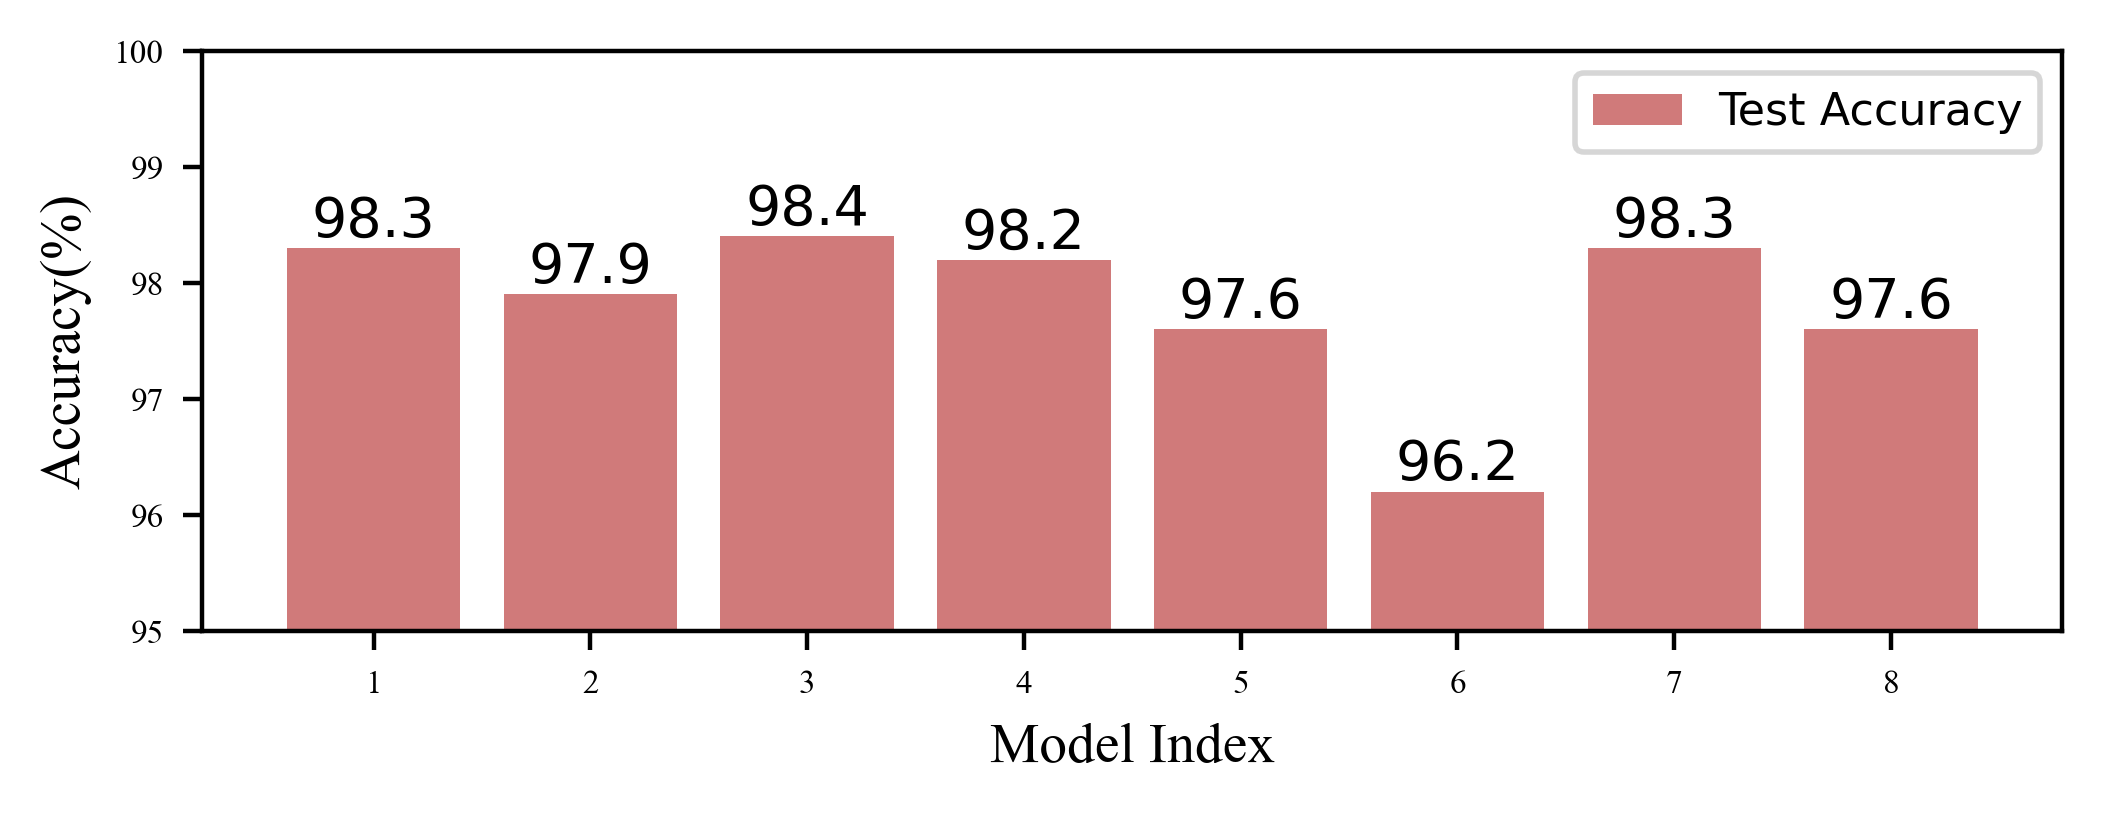

In [ ]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(6,2),dpi=400)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(111)
tr = plt.bar([1,2,3,4,5,6,7,8],acc_8,color='#B22222',alpha = 0.6,label='Test Accuracy')
for a, b in zip([1,2,3,4,5,6,7,8], acc_8):
    plt.text(a, b, '%.1f' % b, ha='center', va='bottom', fontsize=10)
# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 6,
          'ytick.labelsize': 6,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Model Index', fontsize=10,family='Times New Roman')
plt.ylabel('Accuracy(%)', fontsize=10,family='Times New Roman')
plt.ylim((95,100))

plt.legend(loc='best')
plt.savefig("acc_2.png",bbox_inches='tight',facecolor='white',transparent=True)
plt.show()

[55.8, 57.05, 59.5, 59.9, 58.9, 61.4, 69.8, 91.9, 89.9, 91.5, 91.1, 87.9, 92.3, 92.25, 91.8, 91.76, 87.8, 93.2, 93, 93, 93, 92.66, 93.1, 92.5, 93.04, 93.60785483148854, 93.59946661250913, 92.92352939781355, 94.25216280785867, 92.57197256631163, 93.16004290347972, 93.22586860674957, 93.73680375457815, 92.73776289090348, 93.13340386874302, 93.45131759169954, 93.2268896913487, 93.99764461592723, 92.08363445220394, 93.57138251579607, 93.61211566097951, 92.75954277724267, 93.07754867424465, 93.51094794419919, 93.55245867739923, 93.34792555174627, 92.88893687047553, 93.64704384864663, 94.67496955278098, 94.41206969851356, 92.89517380040624, 94.46884585464039, 93.19751182419469, 95.00493479653205, 94.47237111673944, 93.89166397710812, 94.00536083533505, 94.29430862049492, 93.47888256109695, 93.95929389342307, 93.46198534085401, 94.29886750517171, 94.36483193175103, 94.03282148733032, 94.27855617537193, 94.70473017396, 94.46312172134529, 93.67100817894041, 95.12338206752017, 94.82253926041315,

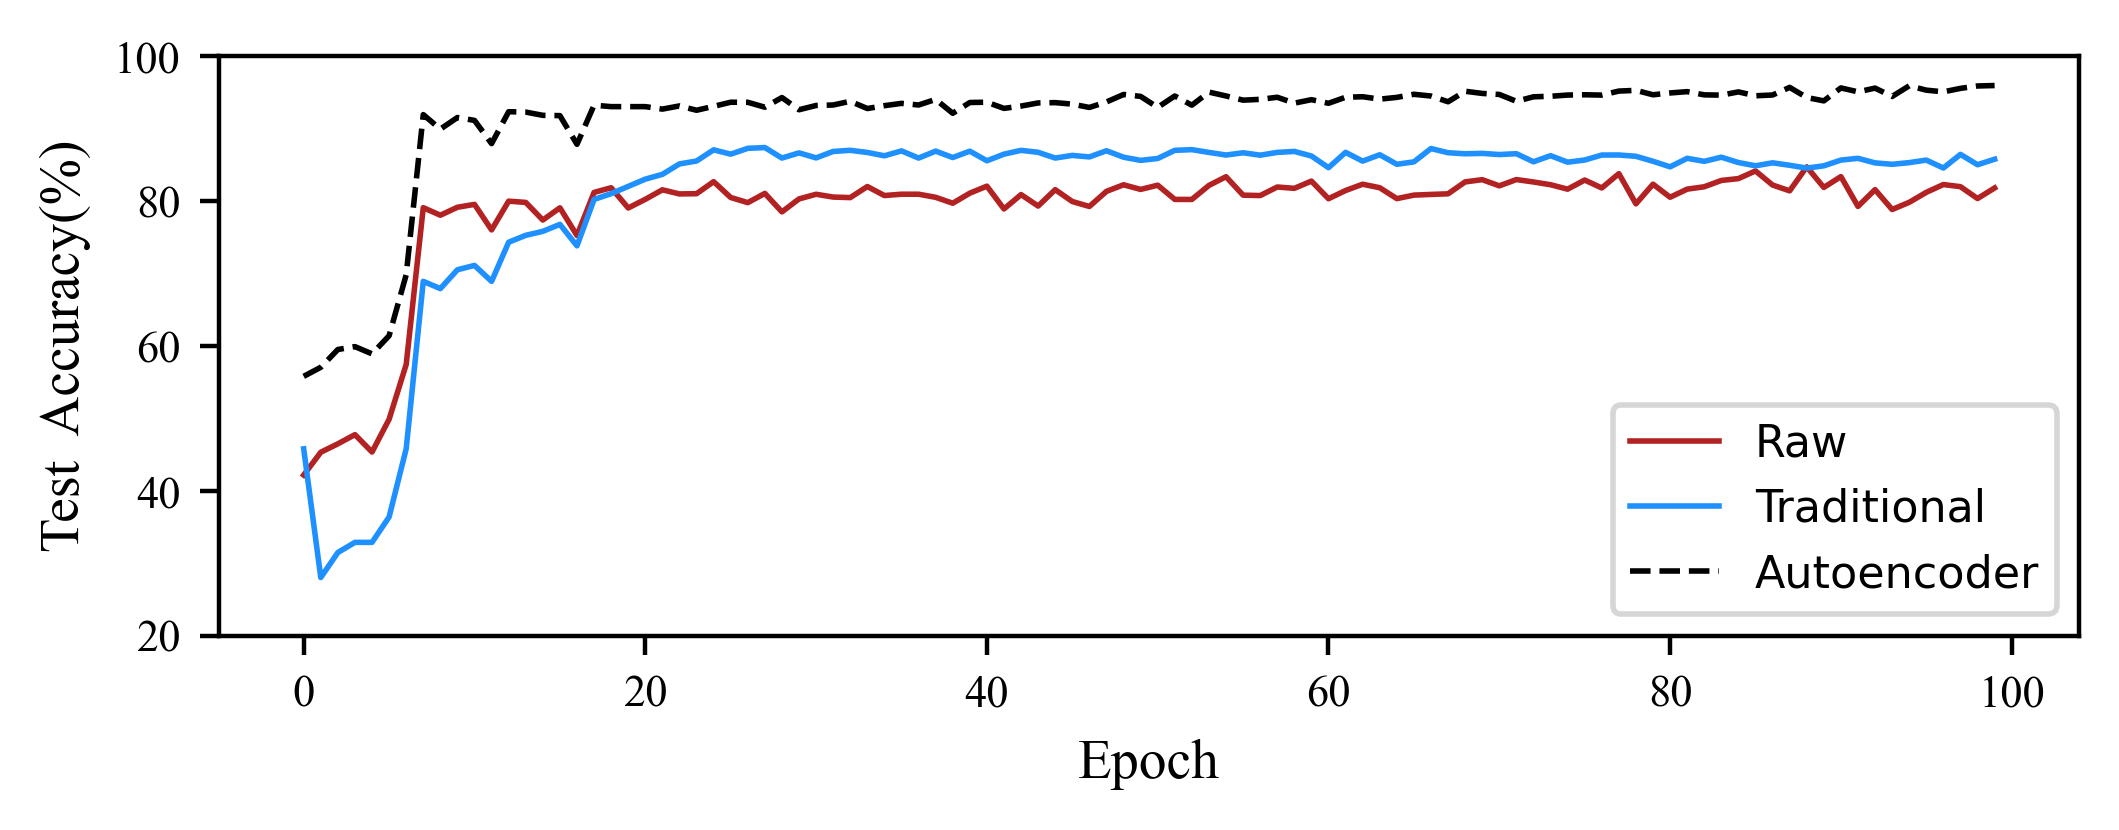

In [ ]:
print(acc_2)
fig= plt.figure(figsize=(6,2),dpi=400)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(111)
t1 = plt.plot(ac_1,color='#B22222',label='Raw',linewidth=1)
t2 = plt.plot(ac_3,color='#1E90FF',label='Traditional',linewidth=1)
t3 = plt.plot(acc_2,color='black',label='Autoencoder',linestyle='--',linewidth=1)

# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 8,
          'ytick.labelsize': 8,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Epoch', fontsize=10,family='Times New Roman')
plt.ylabel('Test  Accuracy(%)', fontsize=10,family='Times New Roman')
plt.ylim((20,100))
plt.legend(loc='best')
plt.savefig("imageaug.png",bbox_inches='tight',facecolor='white',transparent=True)
plt.show()

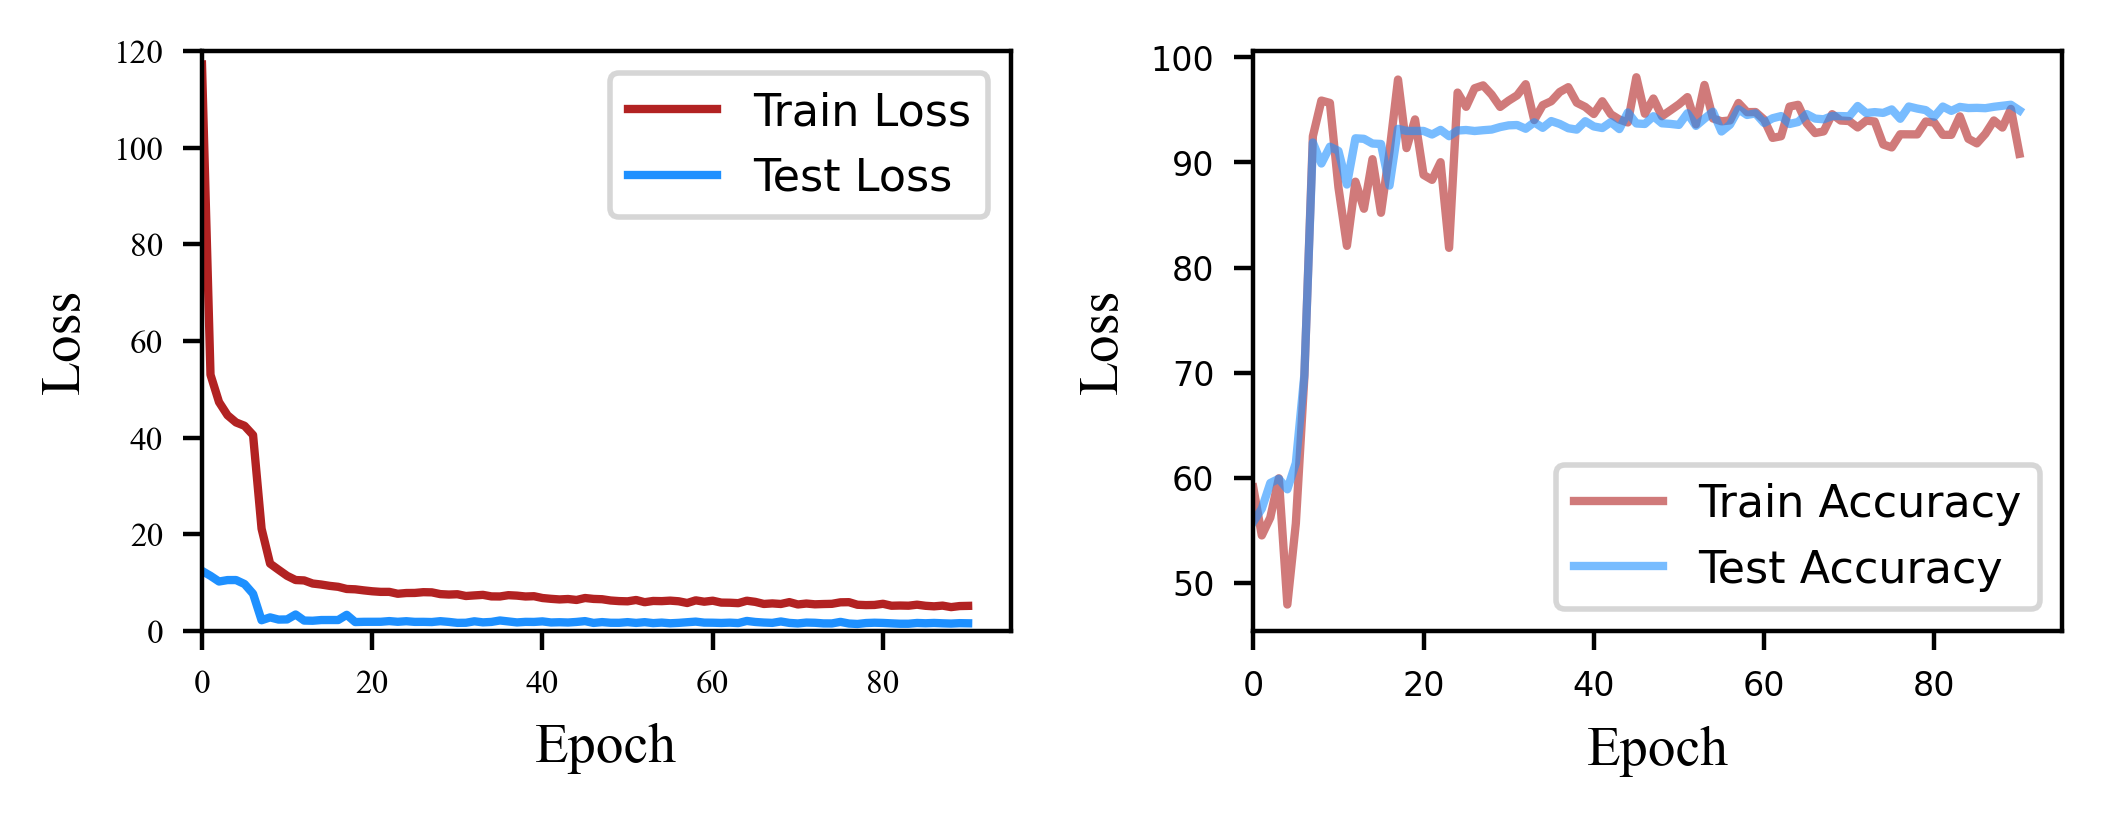

In [ ]:
###wind power&wind speed ----  time
fig= plt.figure(figsize=(6,2),dpi=400)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(121)
tr = plt.plot(train_loss2,color='#B22222',label='Train Loss')
te = plt.plot(test_loss2,color='#1E90FF',label='Test Loss')

# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 6,
          'ytick.labelsize': 6,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Epoch', fontsize=10,family='Times New Roman')
plt.ylabel('Loss', fontsize=10,family='Times New Roman')
plt.ylim((0,120))
plt.xlim((0,95))
plt.legend(loc='best')

ax2 = fig.add_subplot(122)
tr = plt.plot(acc_2,color='#B22222',alpha = 0.6,label='Train Accuracy')
te = plt.plot(acc_te,color='#1E90FF',alpha = 0.6,label='Test Accuracy')

# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 6,
          'ytick.labelsize': 6,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Epoch', fontsize=10,family='Times New Roman')
plt.ylabel('Loss', fontsize=10,family='Times New Roman')
# plt.ylim((0,120))
plt.xlim((0,95))
plt.legend(loc='best')

plt.savefig("loss_1.png",bbox_inches='tight',facecolor='white',transparent=True)
plt.show()